## 1. Descripción del dataset. 

El dataset a analizar consiste en una recolección de las "propinas" generadas por un restaurante. En este podemos encontrar todo un conjunto de información multivariante: la cantidad de propina dejada por un cliente, el género del cliente, si este fumaba o no, etc.

El dataset ha sido descargado del siguiente enlace (https://github.com/mwaskom/seaborn-data/blob/master/tips.csv) y ha sido levemente modificado para poder realizar un proceso de limpieza mínimo.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy.stats import shapiro, iqr, mannwhitneyu, kruskal
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

sns.set()
df = sns.load_dataset('tips')

def add_na(row):
    
    row['total_bill'] = '$' + str(row.total_bill)
    row['tip'] = '$' + str(row.tip)
                                
    if np.random.randint(0, 100) < 3:
        row['total_bill'] = np.nan
    if np.random.randint(0, 100) < 3:
        row['tip'] = np.nan
        
    return row

df = df.apply(add_na, axis=1)

tips = df
del(df)
tips.head()


,total_bill,tip,sex,smoker,day,time,size
0,$16.99,NaN,Female,No,Sun,Dinner,2
1,$10.34,$1.66,Male,No,Sun,Dinner,3
2,$21.01,$3.5,Male,No,Sun,Dinner,3
3,$23.68,NaN,Male,No,Sun,Dinner,2
4,$24.59,$3.61,Female,No,Sun,Dinner,4


## 2. Integración y selección de los datos de interés a analizar. 

Vamos a analizar la relación que existe entre la cantidad de propina dejada por cada usuario (`tip`) y las siguientes variables: `total_bill` (importe total de la comida), `sex` (genero) y `day` (día de la semana); con los dos siguientes objetivos: 

* Exponer las diferencias (si existen) entre los grupos y la cantidad de propina.
* Predecir la propina (target) dada las anteriores variables (features).

Para ello, vamos a recodificar la variable `sex` (0=Female, 1=Male), distinguir la variable `day`(entre 'fin de semana'=0 y 'entre semana'=1) y agrupar la variable `total_bill`. Como podemos observar la variable `day` solo tiene ocurrencias en los días jueves, viernes, sábado y domingo.

In [2]:
def recode_gender(gender):
    
    if gender == 'Female':
        return 0

    elif gender == 'Male':
        return 1

    else:
        return np.nan
    
    
def recode_day(day):
    
    if day in ['Sat', 'Sun']:
        return 0

    elif day in ['Thur', 'Fri']:
        return 1

    else:
        return np.nan   
    
    
def recode_bill(bill, lim=1000):
    
    b = np.round(bill)
    
    if b <= 10:
        return 0

    elif b <= 20:
        return 1
    
    elif b <= lim:
        return 2

    else:
        return np.nan  
    

tips['sex'] = tips.sex.apply(recode_gender)
tips['day'] = tips.day.apply(recode_day)

tips = tips[['tip', 'total_bill', 'sex', 'day']]
tips.head()

,tip,total_bill,sex,day
0,NaN,$16.99,0,0
1,$1.66,$10.34,1,0
2,$3.5,$21.01,1,0
3,NaN,$23.68,1,0
4,$3.61,$24.59,0,0


## 3. Limpieza de los datos.

A continuación, vamos a interrogarnos sobre la presencia de valores perdidos o extremos. Como veremos en la siguiente tabla, el dataset contiene 244 filas y presenta algunos valores vacíos en las dos primeras columnas. Además, podemos observar que ambas son de tipo objeto (carácter) debido a la presencia del símbolo `$`.

Por lo tanto, vamos a eliminar aquellas filas con valores nulos así como corregir los valores numéricos (podemos eliminarlas debido a la naturaleza del análisis - son imputaciones propias).

Respecto a los valores extremos, podemos prever la existencia de estos en la variable `tips` y `total_bill` (podemos suponer que habrá algunos clientes con cuentas elevadas o "tips elevados"); debido a la no normalidad de ambas variables - *hecho observable en la sección 4.2* - vamos a utilizar la distancia interquartil para identificar estos valores (observaciones superiores o inferiores a 3 * IQR); para, acto seguido, reemplazarlos por una medida de centralidad como la mediana debido a la distribución de las variables.

### 3.1. Valores perdidos.

In [3]:
tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 4 columns):
tip           233 non-null object
total_bill    240 non-null object
sex           244 non-null int64
day           244 non-null int64
dtypes: int64(2), object(2)
memory usage: 7.8+ KB


In [4]:
tips.dropna(inplace=True)

tips['total_bill'] = tips.total_bill.apply(lambda x: re.findall('\d+\.\d+', x)[0])
tips['tip'] = tips.tip.apply(lambda x: re.findall('\d+\.\d+', x)[0])

tips['total_bill'] = pd.to_numeric(tips.total_bill, errors='coerce')
tips['tip'] = pd.to_numeric(tips.tip, errors='coerce')

tips['total_bill_rec'] = tips['total_bill'].apply(recode_bill)

tips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229 entries, 1 to 243
Data columns (total 5 columns):
tip               229 non-null float64
total_bill        229 non-null float64
sex               229 non-null int64
day               229 non-null int64
total_bill_rec    229 non-null int64
dtypes: float64(2), int64(3)
memory usage: 10.7 KB


### 3.2. Valores extremos.

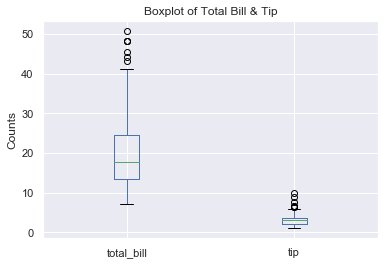

In [5]:
tips.boxplot(column=['total_bill', 'tip'])
plt.title('Boxplot of Total Bill & Tip')
plt.ylabel('Counts')
plt.show()

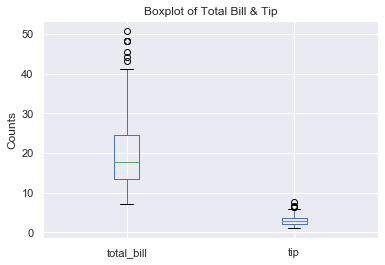

In [6]:
def outliers_to_na(series):
    s = series.copy()
    sup, inf = np.percentile(s, 75) + 3 * iqr(s), np.percentile(s, 25) - 3 * iqr(s)
    s.loc[np.logical_or(s > sup, s < inf)] = s.loc[~np.logical_or(s > sup, s < inf)].median()
    return s

tips['tip'] = outliers_to_na(tips.tip)
tips['total_bill'] = outliers_to_na(tips.total_bill)

tips.boxplot(column=['total_bill', 'tip'])
plt.title('Boxplot of Total Bill & Tip')
plt.ylabel('Counts')
plt.show()

## 4. Análisis de los datos. 

En los siguientes gráficos podemos observar que ambas variables (`total_bill`, `tip`) parecen no tener una distribución normal. Aplicaremos el Test de Shapiro–Wilk para poder afirmar o descartar esta hipótesis.

## 4.1. Comprobación de la normalidad y homogeneidad de la varianza.

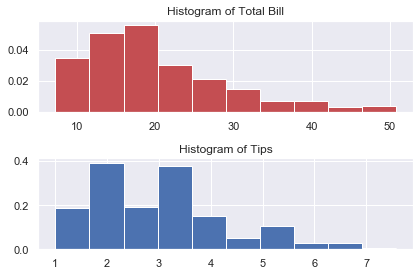

In [7]:
plt.subplot(2, 1, 1)
plt.hist(tips.total_bill, facecolor='r', density=True)
plt.title('Histogram of Total Bill')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.hist(tips.tip, density=True)
plt.title('Histogram of Tips')

plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
sha_total_bill = shapiro(tips.total_bill)
sha_tips = shapiro(tips.tip)
print(f'Los resultados de los test son {sha_total_bill[1]} y {sha_tips[1]}, por lo tanto, ambos test son no significativos y ambas distribuciones no-normales.')

Los resultados de los test son 2.0889583118854915e-10 y 1.1967028257231505e-08, por lo tanto, ambos test son no significativos y ambas distribuciones no-normales.


## 4.2. Aplicación de pruebas estadísticas para comparar los grupos de datos. 

Respecto a las diferencias entre la cantidad de propina dejada por los diferentes grupos; aplicaremos el test de Mann-Whitney debido a dos factores: 
* 1) La no normalidad 
* 2) La desigualdad en el número de instancias para ambos grupos de interés.

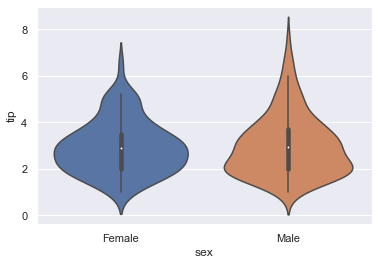

In [9]:
sns.violinplot(x='sex', y='tip', data=tips)
plt.xticks(np.arange(2), ['Female', 'Male'])
plt.show()

Como podemos observar en el grafico anterior no parece haber una diferencia entre hombres y mujeres. Hecho que constataremos con el test estadístico pertinente.

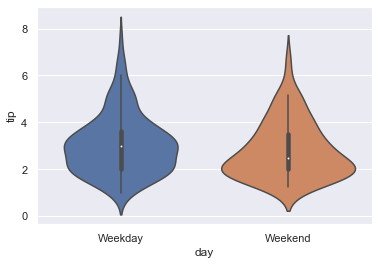

In [10]:
sns.violinplot(x='day', y='tip', data=tips)
plt.xticks(np.arange(2), ['Weekday', 'Weekend'])
plt.show()

Como podemos observar en el grafico anterior parece haber una pequeña diferencia entre las propinas durante el fin de semana o la semana. Hecho que constataremos con el test estadístico pertinente.

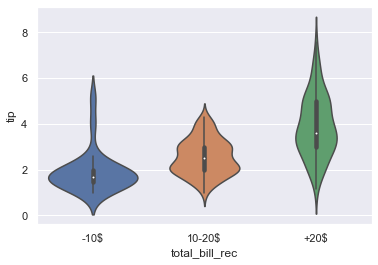

In [11]:
sns.violinplot(x='total_bill_rec', y='tip', data=tips)
plt.xticks(np.arange(3), ['-10$', '10-20$', '+20$'])
plt.show()

Como podemos observar en el grafico anterior, esta parece la diferencia más notable de aquellas testeadas; dándose la diferencia mayor entre los grupos 'menos de 10$' y 'más de 20'. Como hemos expuesto en los casos anteriores, es necesario realizar un test estadístico para contrastar la hipótesis.

In [12]:
sexm = mannwhitneyu(tips.loc[tips.sex == 0, 'tip'], tips.loc[tips.sex == 1, 'tip'], alternative='two-sided')[1]

print(f'La prueba del test estadístico respecto al genero es {sexm}. Por lo tanto, no hay diferencias entre ambos grupos')

La prueba del test estadístico respecto al genero es 0.9082242874909331. Por lo tanto, no hay diferencias entre ambos grupos


In [13]:
daym = mannwhitneyu(tips.loc[tips.day == 0, 'tip'], tips.loc[tips.day == 1, 'tip'], alternative='two-sided')[1]

print(f'La prueba del test estadístico respecto a la temporalidad es {daym}. Por lo tanto, no hay diferencias entre ambos grupos. Aun así parece que con una muestra mayor podriamos conseguir diferenciar ambos grupos (aunque esta diferencia fuera menor).')

La prueba del test estadístico respecto a la temporalidad es 0.12394590204948451. Por lo tanto, no hay diferencias entre ambos grupos. Aun así parece que con una muestra mayor podriamos conseguir diferenciar ambos grupos (aunque esta diferencia fuera menor).


In [14]:
totalm = kruskal(tips.loc[tips.total_bill_rec == 0, 'tip'],
        tips.loc[tips.total_bill_rec == 1, 'tip'],
        tips.loc[tips.total_bill_rec == 2, 'tip']       
)[1]

print(f'La prueba del test estadístico respecto al importe total es {totalm}. Por lo tanto, hay diferencias entre los diferentes grupos. Como hemos podido observar en el gráfico la diferencia es entre los dos grupos mas polarizados.')

La prueba del test estadístico respecto al importe total es 1.0668518874261511e-17. Por lo tanto, hay diferencias entre los diferentes grupos. Como hemos podido observar en el gráfico la diferencia es entre los dos grupos mas polarizados.


## 4.3. Aplicación de algoritmos de Machine Learning para predecir la variable independiente

Respecto a la relación que se establece entre las diferentes variables y la variable de intéres(`tip`), después de realizar el análisis exploratio y test de hipotesis, podemos preever que el rendimiento del modelo que obtendremos será pobre ya que la única variable que parece tener cierto impacto es `total_bill`. Hecho observable en los siguientes dos modelos: 

* Un regression linear con 'cross-validation'.
* Un arbol de decisión con 'cross-validation'.

La metrica mostrada es el coeficiente de determinación (R^2)

In [15]:
X = tips.drop(columns=['tip', 'total_bill_rec']).to_numpy()
y = tips.tip.to_numpy()

reg = LinearRegression()
reg.fit(X, y)
reg.score(X, y)

cross_val_score(LinearRegression(), X, y, cv=10).mean()

0.2672839540694973

In [16]:
cross_val_score(DecisionTreeRegressor(), X, y, cv=10).mean()

-0.5523328180615511

## 5. Resolución del problema.

Como hemos podido observar a lo largo del documento parece que las variables escogidas no tienen un impacto significativo para explicar ambos objetivos propuestos. Una de las propuestas de mejoras en el futuro es explorar con otras variables o añadir efectos de interacción en el modelo.